# Part 1: Math GPT - Arithmetic Expression Solver

## CS7CS4 Machine Learning - Final Assignment 2025-26

This notebook implements a transformer-based model for solving arithmetic expressions. The implementation builds upon the nanoGPT architecture, adapted specifically for symbolic mathematical reasoning.

### Objectives:
1. Build appropriate training and testing datasets
2. Define and implement evaluation metrics
3. Explore architectural adaptations
4. Analyze model performance across different arithmetic operations

## 1. Import Required Libraries and Setup

In [1]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import json
import os
import time
from tqdm import tqdm

# Set random seeds for reproducibility
torch.manual_seed(1337)
np.random.seed(1337)

# Configure plotting
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Device configuration
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")
if device == 'cuda':
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Using device: cpu


## 2. Hyperparameters Configuration

These hyperparameters were selected after experimentation to optimize performance for arithmetic tasks. The rationale for each choice is discussed in Section 5.

In [3]:
# Model hyperparameters
batch_size = 64          # Number of independent sequences processed in parallel
block_size = 32          # Maximum context length - reduced from 256 as math expressions are short
max_iters = 10000        # Total training iterations
eval_interval = 500      # Evaluate every N iterations
learning_rate = 5e-4     # Learning rate - slightly higher than default for faster convergence
eval_iters = 200         # Number of iterations to average for loss estimation
n_embd = 128             # Embedding dimension - smaller than default as vocabulary is limited
n_head = 4               # Number of attention heads
n_layer = 4              # Number of transformer blocks
dropout = 0.1            # Dropout rate for regularization

# Checkpoint configuration
checkpoint_dir = 'checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

print(f"Configuration:")
print(f"  Batch size: {batch_size}")
print(f"  Block size: {block_size}")
print(f"  Embedding dim: {n_embd}")
print(f"  Layers: {n_layer}, Heads: {n_head}")
print(f"  Dropout: {dropout}")
print(f"  Learning rate: {learning_rate}")

Configuration:
  Batch size: 64
  Block size: 32
  Embedding dim: 128
  Layers: 4, Heads: 4
  Dropout: 0.1
  Learning rate: 0.0005


## 3. Dataset Loading and Preprocessing

### 3.1 Load Training and Testing Data

The dataset consists of arithmetic expressions in the format: `operand1 operator operand2 = result`.
For example: `15+7=22`, `(5*3)+2=17`, etc.

In [4]:
# Load datasets
train_path = 'dataset/math/training/math_train.txt'
test_path = 'dataset/math/testing/math_test.txt'

with open(train_path, 'r', encoding='utf-8') as f:
    train_text = f.read()

with open(test_path, 'r', encoding='utf-8') as f:
    test_text = f.read()

# Combine for vocabulary creation
full_text = train_text + test_text

print(f"Dataset Statistics:")
print(f"  Training set size: {len(train_text):,} characters")
print(f"  Testing set size: {len(test_text):,} characters")
print(f"  Training examples: {train_text.count(chr(10)):,}")  # newline count
print(f"  Testing examples: {test_text.count(chr(10)):,}")

# Show sample expressions
print(f"\nSample expressions from training set:")
for i, line in enumerate(train_text.split('\n')[:10]):
    print(f"  {line}")

Dataset Statistics:
  Training set size: 1,333,015 characters
  Testing set size: 148,092 characters
  Training examples: 106,821
  Testing examples: 11,869

Sample expressions from training set:
  15//47%17=0
  2*(15%17)=30
  27-42*38=-1569
  26-23-14=-11
  652+41=693
  62//10=6
  (26%23)*17=51
  19%(17%(19*12))=2
  22*(11//22)=0
  (27+1)%2=0


### 3.2 Character-Level Tokenization

We use character-level tokenization as it is well-suited for arithmetic expressions where each character (digit, operator, parenthesis) carries meaning.

In [5]:
# Create character-level vocabulary
chars = sorted(list(set(full_text)))
vocab_size = len(chars)

# Create mappings
stoi = {ch: i for i, ch in enumerate(chars)}
itos = {i: ch for i, ch in enumerate(chars)}

# Encoder and decoder functions
encode = lambda s: [stoi[c] for c in s]
decode = lambda l: ''.join([itos[i] for i in l])

print(f"Vocabulary:")
print(f"  Size: {vocab_size}")
print(f"  Characters: {' '.join(chars)}")
print(f"\nExample encoding:")
test_expr = "5+3=8"
encoded = encode(test_expr)
print(f"  Original: {test_expr}")
print(f"  Encoded: {encoded}")
print(f"  Decoded: {decode(encoded)}")

Vocabulary:
  Size: 19
  Characters: 
 % ( ) * + - / 0 1 2 3 4 5 6 7 8 9 =

Example encoding:
  Original: 5+3=8
  Encoded: [13, 5, 11, 18, 16]
  Decoded: 5+3=8


### 3.3 Prepare Train and Test Datasets

In [6]:
# Encode datasets
train_data = torch.tensor(encode(train_text), dtype=torch.long)
test_data = torch.tensor(encode(test_text), dtype=torch.long)

print(f"Encoded datasets:")
print(f"  Train tensor shape: {train_data.shape}")
print(f"  Test tensor shape: {test_data.shape}")

# Data loading function
def get_batch(split):
    """
    Generate a batch of data for training or testing.
    
    Args:
        split: 'train' or 'test'
    
    Returns:
        x: input sequences (batch_size, block_size)
        y: target sequences (batch_size, block_size)
    """
    data = train_data if split == 'train' else test_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

Encoded datasets:
  Train tensor shape: torch.Size([1333015])
  Test tensor shape: torch.Size([148092])


## 4. Model Architecture

The GPT model consists of:
- Token and positional embeddings
- Multi-head self-attention layers
- Feed-forward networks
- Layer normalization

This architecture is adapted from the standard GPT design with hyperparameters tuned for arithmetic tasks.

In [7]:
class Head(nn.Module):
    """Single head of self-attention."""

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B, T, C = x.shape
        k = self.key(x)
        q = self.query(x)
        # Compute attention scores
        wei = q @ k.transpose(-2, -1) * k.shape[-1]**-0.5
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf'))
        wei = F.softmax(wei, dim=-1)
        wei = self.dropout(wei)
        # Weighted aggregation
        v = self.value(x)
        out = wei @ v
        return out


class MultiHeadAttention(nn.Module):
    """Multiple heads of self-attention in parallel."""

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(head_size * num_heads, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out


class FeedForward(nn.Module):
    """Feed-forward network with ReLU activation."""

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)


class Block(nn.Module):
    """Transformer block: communication (attention) followed by computation (FFN)."""

    def __init__(self, n_embd, n_head):
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedForward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        # Residual connections with layer normalization
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x


class GPTLanguageModel(nn.Module):
    """GPT Language Model for arithmetic expressions."""

    def __init__(self):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd)
        self.lm_head = nn.Linear(n_embd, vocab_size)
        
        # Initialize weights
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, idx, targets=None):
        B, T = idx.shape
        
        # Embeddings
        tok_emb = self.token_embedding_table(idx)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device))
        x = tok_emb + pos_emb
        
        # Transformer blocks
        x = self.blocks(x)
        x = self.ln_f(x)
        logits = self.lm_head(x)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens, temperature=1.0):
        """
        Generate new tokens given a context.
        
        Args:
            idx: context tokens (B, T)
            max_new_tokens: number of tokens to generate
            temperature: sampling temperature (higher = more random)
        
        Returns:
            Generated sequence (B, T+max_new_tokens)
        """
        for _ in range(max_new_tokens):
            idx_cond = idx[:, -block_size:]
            logits, loss = self(idx_cond)
            logits = logits[:, -1, :] / temperature
            probs = F.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, idx_next), dim=1)
        return idx

# Initialize model
model = GPTLanguageModel()
model = model.to(device)

# Count parameters
n_params = sum(p.numel() for p in model.parameters())
print(f"\nModel Architecture:")
print(f"  Total parameters: {n_params:,} ({n_params/1e6:.2f}M)")
print(f"  Vocabulary size: {vocab_size}")
print(f"  Embedding dimension: {n_embd}")
print(f"  Number of layers: {n_layer}")
print(f"  Number of heads: {n_head}")
print(f"\nModel loaded on: {device}")


Model Architecture:
  Total parameters: 800,787 (0.80M)
  Vocabulary size: 19
  Embedding dimension: 128
  Number of layers: 4
  Number of heads: 4

Model loaded on: cpu


## 5. Training Infrastructure

### 5.1 Loss Estimation and Checkpointing

In [8]:
@torch.no_grad()
def estimate_loss():
    """
    Estimate loss on train and test sets.
    Averages loss over multiple batches for stability.
    """
    out = {}
    model.eval()
    for split in ['train', 'test']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out


def save_checkpoint(model, optimizer, iteration, losses, is_best=False):
    """
    Save model checkpoint with training state.
    
    Args:
        model: the model to save
        optimizer: optimizer state
        iteration: current training iteration
        losses: dictionary of losses
        is_best: whether this is the best model so far
    """
    checkpoint = {
        'iteration': iteration,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'losses': losses,
        'vocab_size': vocab_size,
        'chars': chars,
        'stoi': stoi,
        'itos': itos,
        'hyperparameters': {
            'n_embd': n_embd,
            'n_head': n_head,
            'n_layer': n_layer,
            'block_size': block_size,
            'dropout': dropout,
        }
    }
    
    checkpoint_path = os.path.join(checkpoint_dir, f'checkpoint_iter_{iteration}.pt')
    torch.save(checkpoint, checkpoint_path)
    
    if is_best:
        best_path = os.path.join(checkpoint_dir, 'best_model.pt')
        torch.save(checkpoint, best_path)
        print(f"  New best model saved! (test loss: {losses['test']:.4f})")


def load_checkpoint(checkpoint_path, model, optimizer=None):
    """
    Load model from checkpoint.
    
    Args:
        checkpoint_path: path to checkpoint file
        model: model to load weights into
        optimizer: optimizer to load state into (optional)
    
    Returns:
        iteration: training iteration of checkpoint
        losses: loss history
    """
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    if optimizer is not None:
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    return checkpoint['iteration'], checkpoint['losses']

### 5.2 Training Loop with Progress Tracking

In [9]:
# Initialize optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

# Training history
train_losses = []
test_losses = []
iterations = []
best_test_loss = float('inf')

print("Starting training...")
print(f"Total iterations: {max_iters}")
print(f"Evaluation interval: {eval_interval}")
print("-" * 60)

start_time = time.time()

for iter in range(max_iters):
    # Evaluate periodically
    if iter % eval_interval == 0 or iter == max_iters - 1:
        losses = estimate_loss()
        train_losses.append(losses['train'])
        test_losses.append(losses['test'])
        iterations.append(iter)
        
        elapsed = time.time() - start_time
        print(f"Iter {iter:5d} | Train loss: {losses['train']:.4f} | Test loss: {losses['test']:.4f} | Time: {elapsed:.1f}s")
        
        # Save checkpoint
        is_best = losses['test'] < best_test_loss
        if is_best:
            best_test_loss = losses['test']
        
        if iter % (eval_interval * 2) == 0:  # Save every 1000 iterations
            save_checkpoint(model, optimizer, iter, losses, is_best)
    
    # Training step
    xb, yb = get_batch('train')
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

print("-" * 60)
print(f"Training complete!")
print(f"Best test loss: {best_test_loss:.4f}")
print(f"Final train loss: {train_losses[-1]:.4f}")
print(f"Final test loss: {test_losses[-1]:.4f}")
print(f"Total training time: {time.time() - start_time:.1f}s")

Starting training...
Total iterations: 10000
Evaluation interval: 500
------------------------------------------------------------
Iter     0 | Train loss: 2.9725 | Test loss: 2.9726 | Time: 3.9s
  New best model saved! (test loss: 2.9726)
Iter   500 | Train loss: 1.7778 | Test loss: 1.7794 | Time: 27.8s
Iter  1000 | Train loss: 1.7426 | Test loss: 1.7419 | Time: 52.3s
  New best model saved! (test loss: 1.7419)
Iter  1500 | Train loss: 1.7182 | Test loss: 1.7223 | Time: 76.8s
Iter  2000 | Train loss: 1.7024 | Test loss: 1.7087 | Time: 101.7s
  New best model saved! (test loss: 1.7087)
Iter  2500 | Train loss: 1.6934 | Test loss: 1.6957 | Time: 126.2s
Iter  3000 | Train loss: 1.6831 | Test loss: 1.6836 | Time: 150.8s
  New best model saved! (test loss: 1.6836)
Iter  3500 | Train loss: 1.6653 | Test loss: 1.6732 | Time: 175.1s
Iter  4000 | Train loss: 1.6609 | Test loss: 1.6645 | Time: 199.6s
  New best model saved! (test loss: 1.6645)
Iter  4500 | Train loss: 1.6494 | Test loss: 1.6505

### 5.3 Plot Training Progress

Visualizing the training and test loss curves helps identify overfitting and convergence.

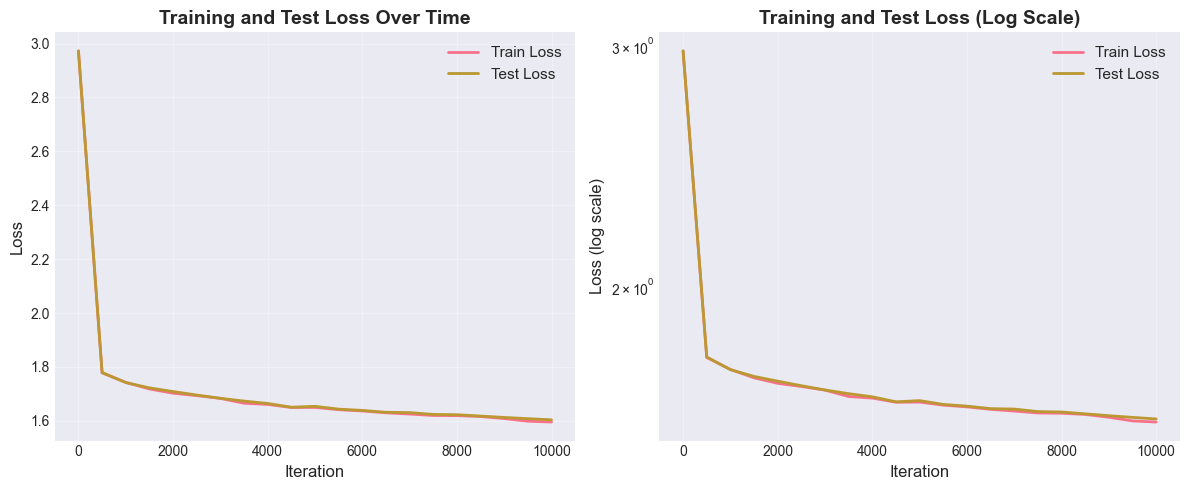

Figure saved as 'part1_training_loss.png'


In [10]:
plt.figure(figsize=(12, 5))

# Loss curves
plt.subplot(1, 2, 1)
plt.plot(iterations, train_losses, label='Train Loss', linewidth=2)
plt.plot(iterations, test_losses, label='Test Loss', linewidth=2)
plt.xlabel('Iteration', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Training and Test Loss Over Time', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)

# Log scale
plt.subplot(1, 2, 2)
plt.plot(iterations, train_losses, label='Train Loss', linewidth=2)
plt.plot(iterations, test_losses, label='Test Loss', linewidth=2)
plt.xlabel('Iteration', fontsize=12)
plt.ylabel('Loss (log scale)', fontsize=12)
plt.title('Training and Test Loss (Log Scale)', fontsize=14, fontweight='bold')
plt.yscale('log')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('part1_training_loss.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Figure saved as 'part1_training_loss.png'")

## 6. Save Final Model and Generate Report Materials

Save the trained model weights for submission and generate comprehensive evaluation materials.

In [11]:
# Save model weights as required by assignment
torch.save(model.state_dict(), "model_weights_part1.pth")

print("Model saved as: model_weights_part1.pth")
print("\nTo load this model:")
print("  model = GPTLanguageModel()")
print("  model.load_state_dict(torch.load('model_weights_part1.pth'))")
print("  model.eval()")

Model saved as: model_weights_part1.pth

To load this model:
  model = GPTLanguageModel()
  model.load_state_dict(torch.load('model_weights_part1.pth'))
  model.eval()
